In [127]:
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')


In [103]:
colnames = ['Утиль Сим', 'Утиль Кредит', 'Утиль Инвест', 'Нарушения', 'Геймификация', 'Успешность', "Процент отказов"]

## Загрузка данных

In [35]:
data = pd.read_excel('March_done.xlsx',
                     index_col=0,)

In [36]:
data_feb = pd.read_excel("Feb.xlsx", index_col=0).drop_duplicates('id')

In [38]:
data_jan = pd.read_excel("Jan.xlsx", index_col=0).drop_duplicates('id')

In [41]:
concated_df = pd.concat([data, data_feb, data_jan])

In [42]:
ids = merged_data.id
merge1 =pd.merge(data_jan, data_feb, on='id', suffixes=['_1', '_2'])
merge1 = merge1.set_index('id').loc[ids]
merge2 = pd.merge(data.drop('target', axis=1), data_feb,  on='id', suffixes=['_1', '_2'])
merge2 = merge2.set_index('id').loc[ids]

In [43]:
Y = pd.concat([data.drop('target', axis=1).set_index('id').loc[ids], data_jan.set_index('id').loc[ids]])

## Модель предсказания

In [44]:

class ModelWrap():
    def __init__(self, model):
        self.model = model  # Инициализация модели
        
    def fit_scaler(self, X, y):
        self.X_scaler = StandardScaler()  # Создание объекта StandardScaler для признаков X
        self.Y_scaler = StandardScaler()  # Создание объекта StandardScaler для целевых значений y
        self.X_scaler.fit(X)  # Обучение StandardScaler для признаков X
        self.Y_scaler.fit(y)  # Обучение StandardScaler для целевых значений y
        
    def fit(self, X_train, y_train, **kwargs):
        X_train_scaled = self.X_scaler.transform(X_train)  # Преобразование масштаба признаков X_train
        y_train_scaled = self.Y_scaler.transform(y_train)  # Преобразование масштаба целевых значений y_train
        
        self.model.fit(X_train_scaled, y_train_scaled, **kwargs)  # Обучение модели с масштабированными данными
        
    def evaluate(self, X_test, y_test):
        X_test_scaled = self.X_scaler.transform(X_test)  # Преобразование масштаба признаков X_test
        y_test_scaled = self.Y_scaler.transform(y_test)  # Преобразование масштаба целевых значений y_test
        
        print(self.model.evaluate(X_test_scaled, y_test_scaled))  # Оценка модели на тестовых данных
    
    def predict(self, X):
        X_scaled = self.X_scaler.transform(X)  # Преобразование масштаба признаков X
        y_pred_scaled = self.model.predict(X_scaled)  # Получение предсказанных значений с масштабированными признаками
        y_pred = self.Y_scaler.inverse_transform(y_pred_scaled)  # Обратное преобразование масштабированных предсказанных значений
        return y_pred  # Возврат предсказанных значений


In [45]:
X_ = pd.concat([merge1, merge2])  # Объединение данных merge1 и merge2 вместе для признаков X
Y_ = pd.concat([data.drop('target', axis=1).set_index('id').loc[ids], data_jan.set_index('id').loc[ids]])  # Объединение данных для целевых значений Y

# Разделение данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.2, random_state=36)

# Определение архитектуры модели
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  # Полносвязный слой с 64 нейронами и функцией активации ReLU
    tf.keras.layers.Dropout(0.2),  # Слой регуляризации Dropout с коэффициентом отсева 0.2
    tf.keras.layers.Dense(16, activation='relu'),  # Полносвязный слой с 16 нейронами и функцией активации ReLU
    tf.keras.layers.Dense(7)  # Выходной полносвязный слой с 7 нейронами (прогнозы)
])

opt = tf.optimizers.Adam(learning_rate=1e-3)  # Оптимизатор Adam с заданной скоростью обучения

# Сборка модели
model.compile(optimizer=opt, loss='mean_squared_error',)  # Компиляция модели с функцией потерь mean_squared_error
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)  # Остановка обучения при отсутствии улучшения на протяжении 5 эпох

# Обучение модели
model = ModelWrap(model)  # Обертка модели
model.fit_scaler(X_, Y_)  # Масштабирование данных
model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=0, callbacks=[callback],)  # Обучение модели
# Оценка модели
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
preds = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6164 
0.6034060120582581
Test Loss: None
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [46]:
model.model.save("models/v1.0.keras")

In [47]:
def save_model_wrap(model_wrap, base_dir):
    # Создание директории, если она не существует
    os.makedirs(base_dir, exist_ok=True)
    
    # Сохранение модели Keras
    model_path = os.path.join(base_dir, 'model.keras')
    save_model(model_wrap.model, model_path)
    
    # Сохранение скейлеров
    scaler_path = os.path.join(base_dir, 'scalers.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump((model_wrap.X_scaler, model_wrap.Y_scaler), f)

def load_model_wrap(base_dir):
    # Загрузка модели Keras
    model_path = os.path.join(base_dir, 'model.keras')
    model = load_model(model_path)
    
    # Загрузка скейлеров
    scaler_path = os.path.join(base_dir, 'scalers.pkl')
    with open(scaler_path, 'rb') as f:
        X_scaler, Y_scaler = pickle.load(f)
        
    # Создание нового экземпляра ModelWrap и установка модели и скейлеров
    model_wrap = ModelWrap(model)
    model_wrap.X_scaler = X_scaler
    model_wrap.Y_scaler = Y_scaler
    
    return model_wrap


In [54]:
# report1 = pd.DataFrame(columns=y_test.columns) 

In [55]:
# report1.loc["M3"] = [mean_absolute_error(y_test[col], preds[:, i]) for i, col in enumerate(y_test.columns)]


In [56]:
for i, col in enumerate(y_test.columns):
    print(col , mean_absolute_error(y_test[col], preds[:, i]) / y_test[col].mean())

util_per_offer_sim 0.637895827832672
util_per_offer_kk 0.621047880792758
util_per_offer_invest 1.704586495337436
violations 1.0218475225971246
game 0.36093332890009444
success 0.042035252319055284
refuse_pct 0.8004051279464853


<Axes: >

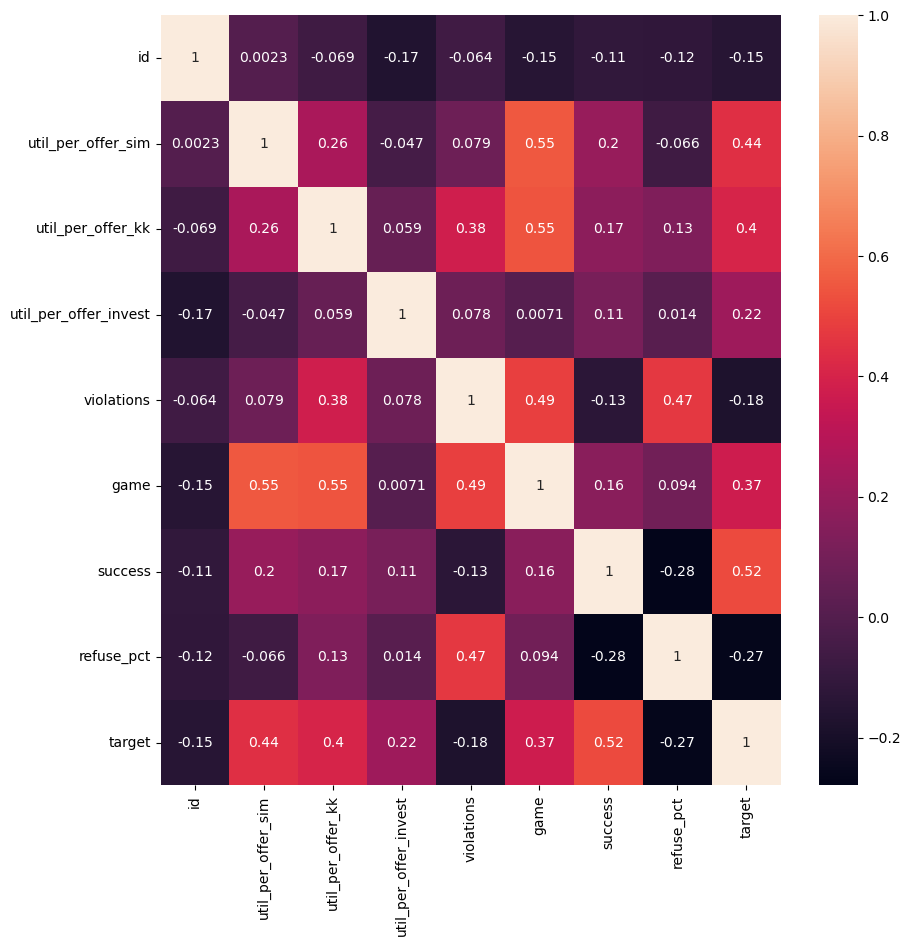

In [57]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)


In [58]:
data.describe().loc[['mean', '50%']].T.to_clipboard()

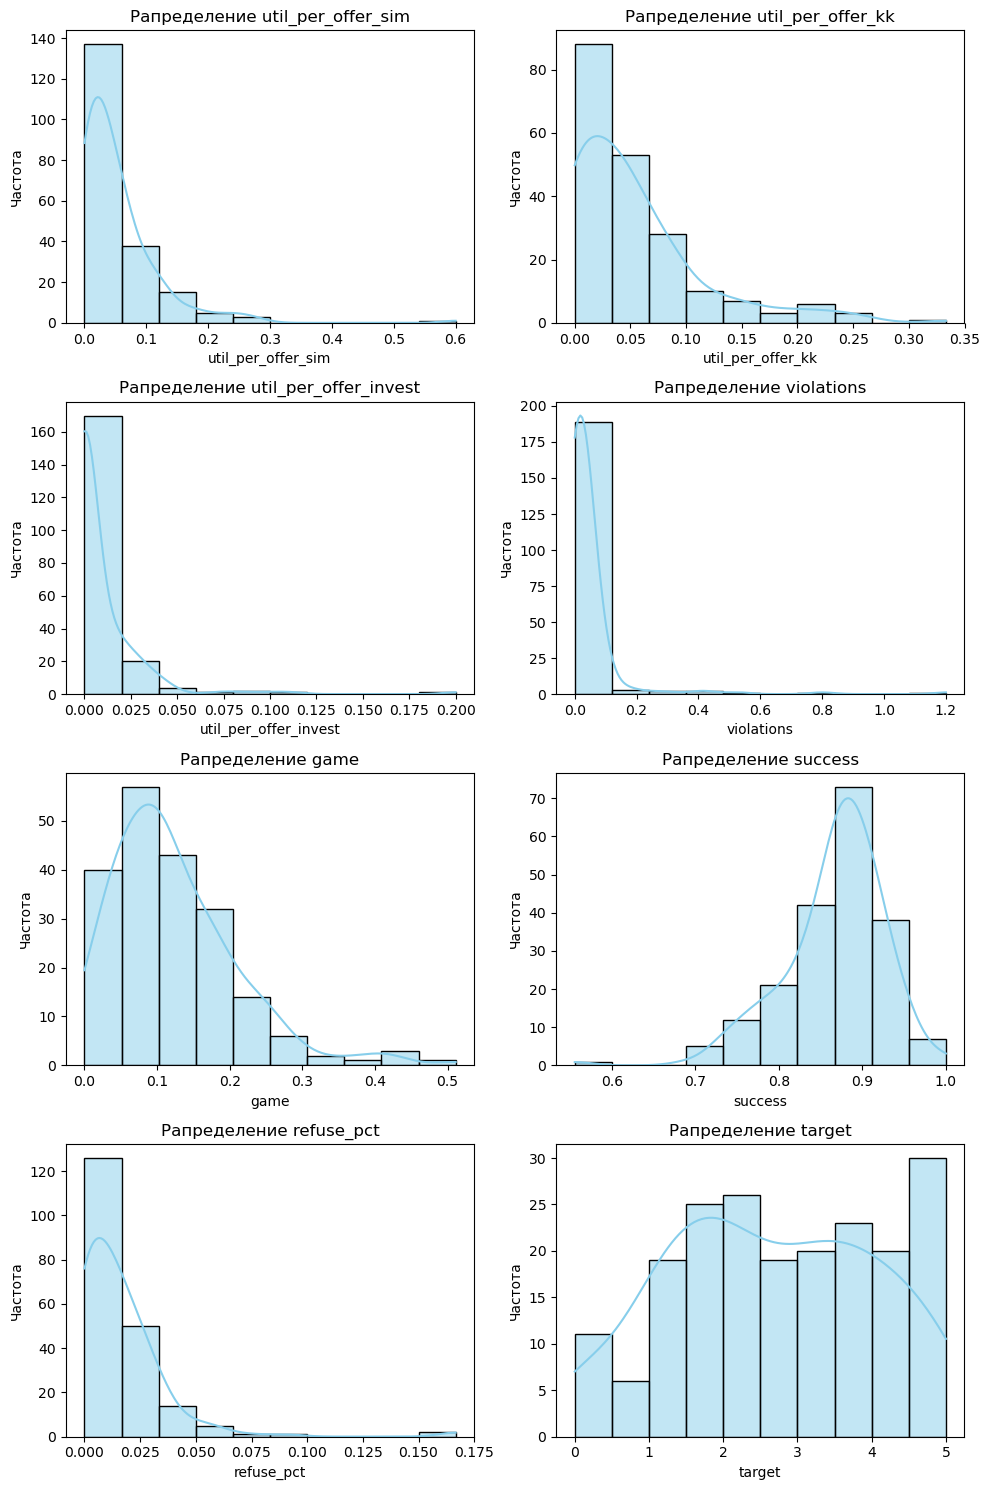

In [59]:
fig, axes = plt.subplots(4, 2, figsize=(10, 15))  # Создание сетки графиков размером 4x2
columns = data.columns[1:]  # Получение названий всех столбцов, кроме первого

# Построение распределения для каждого столбца
for i, ax in enumerate(axes.flatten()):
    if i < len(columns):
        sns.histplot(data[columns[i]], kde=True, bins=10, color='skyblue', ax=ax)  # Построение гистограммы с ядерной оценкой плотности
        ax.set_title(f'Распределение {columns[i]}')  # Установка заголовка графика
        ax.set_xlabel(columns[i])  # Установка подписи по оси X
        ax.set_ylabel('Частота')  # Установка подписи по оси Y
    else:
        ax.remove()  # Удаление пустых подграфиков, если столбцов меньше 9

plt.tight_layout()  # Установка компактного расположения графиков
plt.savefig('rr.png')  # Сохранение графика в файл
plt.show()  # Отображение графика


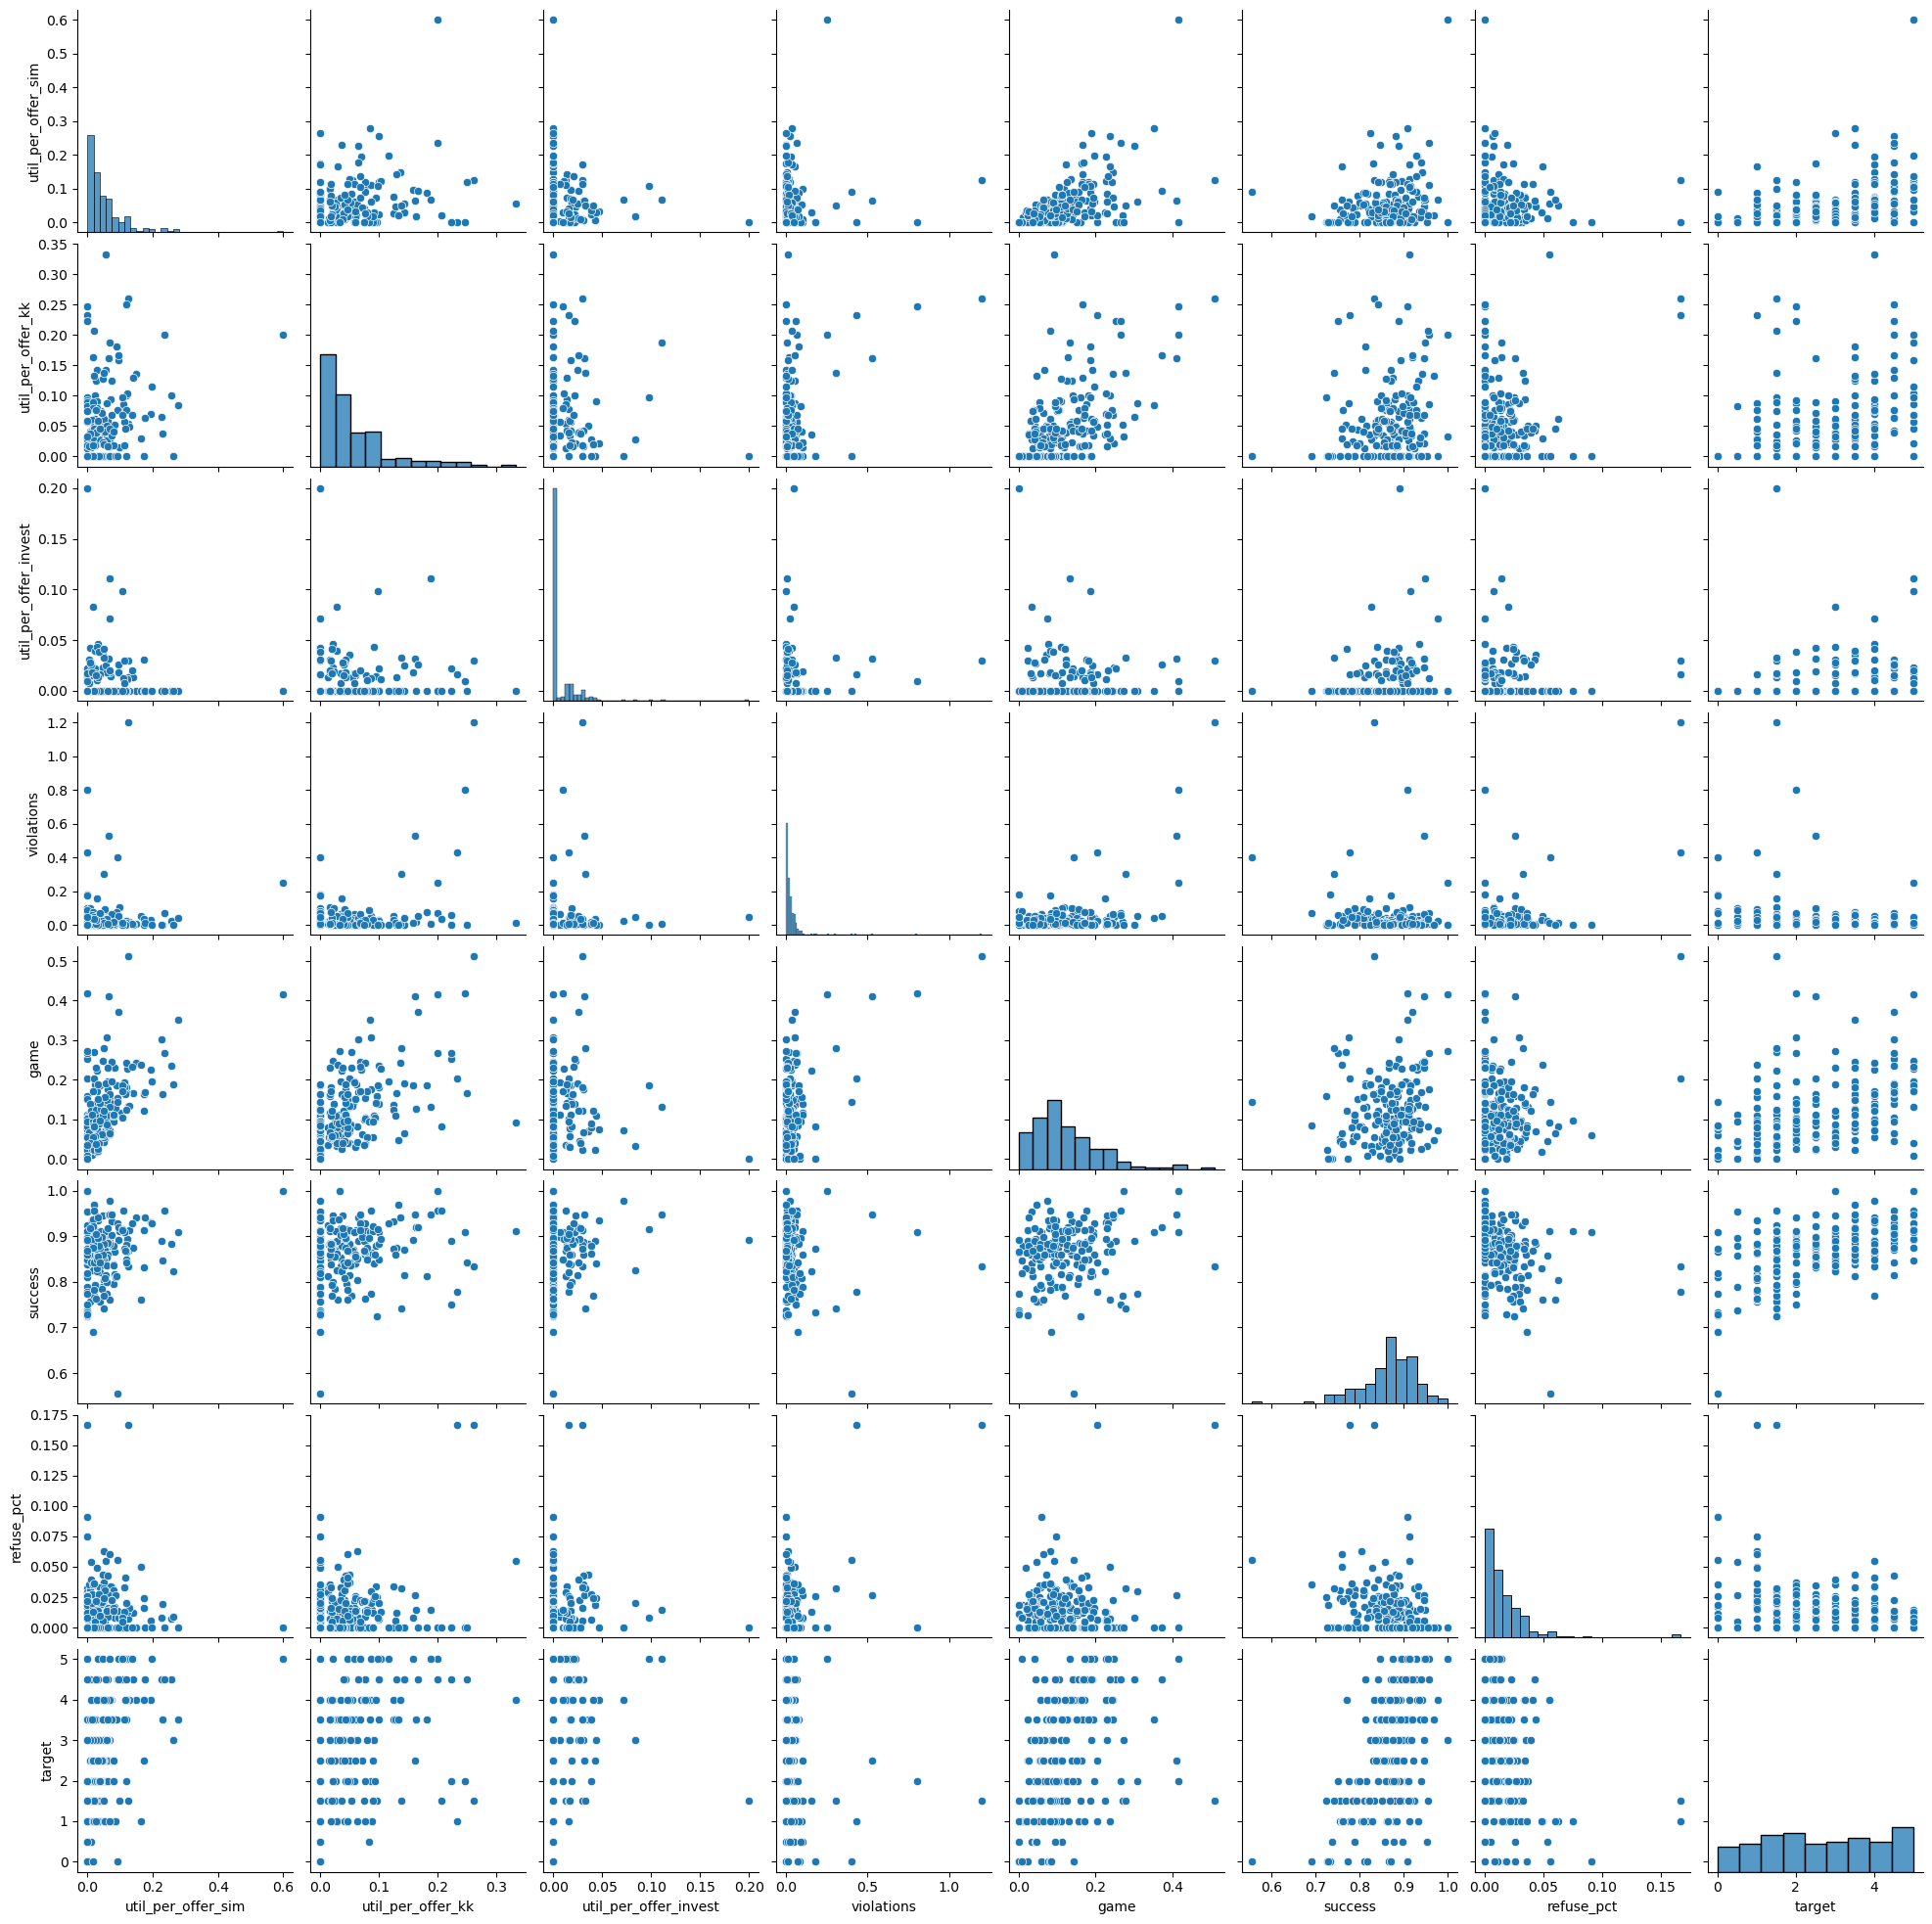

In [60]:
sns.pairplot(data.drop('id', axis=1))
plt.show()

In [61]:
data
X = data.drop(['target', 'id'], axis=1)
Y = data.target

# Classification

<BarContainer object of 11 artists>

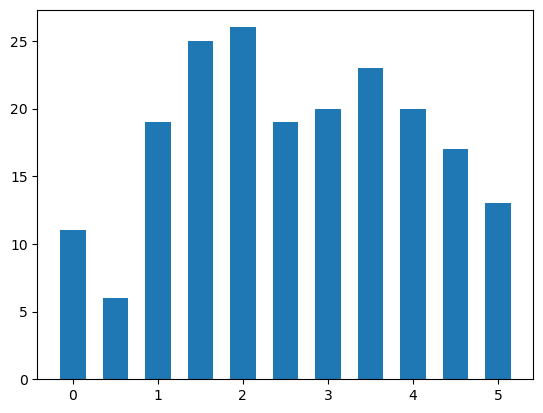

In [62]:
s = Y.value_counts()
plt.bar(s.index, s.values, width=0.3)

In [67]:
def fit_classification(classifiers, X_train, X_test, Y_train, Y_test):
    report = []  # Создание списка для хранения отчетов о моделях
    for clf in classifiers:  # Проход по всем классификаторам из списка
        t = {"Model": repr(clf)}  # Создание словаря для хранения информации о текущей модели
        clf.fit(X_train, Y_train)  # Обучение текущей модели на обучающих данных
        pred = clf.predict(X_test)  # Получение предсказаний модели на тестовых данных
        t["Acc"] = accuracy_score(Y_test, pred)  # Вычисление точности модели и добавление ее в словарь
        t["Acc_simple"] = accuracy_score(Y_test.astype(float).round(0).astype(str), pred.astype(float).round(0).astype(str))  # Вычисление упрощенной точности модели и добавление ее в словарь
        report.append(t)  # Добавление словаря с информацией о модели в список отчетов
    return pd.DataFrame(report)  # Возврат отчета в виде DataFrame


In [68]:
knn_clf = KNeighborsClassifier()
svm_clf = SVC(kernel='rbf')
GB_clf = GradientBoostingClassifier()
rf_clf = RandomForestClassifier(50)
mlp_clf = MLPClassifier(hidden_layer_sizes=(10, 5), learning_rate_init=1e-2, tol=1e-9, max_iter=10000, n_iter_no_change=100)
classifiers = [knn_clf, svm_clf, GB_clf, rf_clf, mlp_clf]

In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.astype(str), test_size=0.2, random_state=10)
report2 = fit_classification(classifiers, X_train, X_test, Y_train, Y_test)
report2

,Model,Acc,Acc_simple
0,KNeighborsClassifier(),0.175,0.600
1,SVC(),0.050,0.250
2,GradientBoostingClassifier(),0.175,0.425
3,RandomForestClassifier(n_estimators=50),0.225,0.450
4,"MLPClassifier(hidden_layer_sizes=(10, 5), lear...",0.225,0.450


In [72]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.astype(str), test_size=0.2, random_state=10)
sampler = SMOTE(random_state=36, k_neighbors=4, )
X_train, Y_train = sampler.fit_resample(X_train, Y_train)
fit_classification(classifiers, X_train, X_test, Y_train, Y_test).to_clipboard()

In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.round(0).astype(str), test_size=0.2, random_state=10)
fit_classification(classifiers, X_train, X_test, Y_train, Y_test)

,Model,Acc,Acc_simple
0,KNeighborsClassifier(),0.500,0.500
1,SVC(),0.550,0.550
2,GradientBoostingClassifier(),0.525,0.525
3,RandomForestClassifier(n_estimators=50),0.550,0.550
4,"MLPClassifier(hidden_layer_sizes=(10, 5), lear...",0.575,0.575


In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.round(0).astype(str), test_size=0.2, random_state=10)
sampler = SMOTE(random_state=36, k_neighbors=4)
X_train, Y_train = sampler.fit_resample(X_train, Y_train)
fit_classification(classifiers, X_train, X_test, Y_train, Y_test)

,Model,Acc,Acc_simple
0,KNeighborsClassifier(),0.400,0.400
1,SVC(),0.300,0.300
2,GradientBoostingClassifier(),0.450,0.450
3,RandomForestClassifier(n_estimators=50),0.550,0.550
4,"MLPClassifier(hidden_layer_sizes=(10, 5), lear...",0.475,0.475


# Regression

In [79]:
def find_nearest(array, values):
    array = np.fromiter(array, float)
    values = np.array(values)
    idx = (np.abs(array[:, None] - values[None, :])).argmin(0)
    return array[idx]

In [80]:
grboots_regr = GradientBoostingRegressor()
knn_regr = KNeighborsRegressor(n_neighbors=2)
forest_regr = RandomForestRegressor()
regr = LinearRegression()
mlp_regr = MLPRegressor(hidden_layer_sizes=(10,5),
                        max_iter=10000,n_iter_no_change=100,
                        learning_rate_init=5e-4,
                        tol=1e-5, )

In [81]:
def fit_regression(regressors, X_train, X_test, Y_train, Y_test):
    report = []  # Создание списка для хранения отчетов о регрессорах
    for regr in regressors:  # Проход по всем регрессорам из списка
        t = {"Model": repr(regr)}  # Создание словаря для хранения информации о текущем регрессоре
        regr.fit(X_train, Y_train)  # Обучение текущего регрессора на обучающих данных
        pred = find_nearest([0, 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ], regr.predict(X_test))  # Получение предсказаний регрессора на тестовых данных и округление до ближайшего значения из списка
        true = find_nearest([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ], Y_test)  # Округление истинных значений до ближайшего значения из списка
        t["MAE"]=  mean_absolute_error(Y_test, regr.predict(X_test))  # Вычисление средней абсолютной ошибки (MAE) и добавление ее в словарь
        t["MSE"]=  mean_squared_error(Y_test, regr.predict(X_test))  # Вычисление среднеквадратичной ошибки (MSE) и добавление ее в словарь
        t["Acc"]= accuracy_score(true.astype(str), pred.astype(str))  # Вычисление точности (Acc) и добавление ее в словарь
        t["Acc_simple"] = accuracy_score(true.astype(float).round(0).astype(str),  pred.astype(float).round(0).astype(str))  # Вычисление упрощенной точности (Acc_simple) и добавление ее в словарь
        report.append(t)  # Добавление словаря с информацией о регрессоре в список отчетов
    return pd.DataFrame(report)  # Возврат отчета в виде DataFrame


In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

In [83]:
regressors = [regr, forest_regr, mlp_regr, grboots_regr, knn_regr]
fit_regression(regressors, X_train, X_test, Y_train, Y_test)

,Model,MAE,MSE,Acc,Acc_simple
0,LinearRegression(),0.944403,1.411255,0.200,0.450
1,RandomForestRegressor(),0.785250,1.274713,0.275,0.575
2,"MLPRegressor(hidden_layer_sizes=(10, 5), learn...",0.758839,1.197965,0.250,0.525
3,GradientBoostingRegressor(),0.745718,1.247574,0.275,0.550
4,KNeighborsRegressor(n_neighbors=2),1.043750,1.745313,0.150,0.450


In [84]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
regressors = [regr, forest_regr, mlp_regr, grboots_regr, forest_regr, knn_regr]
sampler = SMOTE(random_state=36, k_neighbors=4)
X_train, Y_train = sampler.fit_resample(X_train, Y_train.astype(str))
fit_regression(regressors, X_train, X_test, Y_train.astype(float), Y_test)

,Model,MAE,MSE,Acc,Acc_simple
0,LinearRegression(),1.005079,1.652200,0.175,0.400
1,RandomForestRegressor(),0.813625,1.325751,0.225,0.550
2,"MLPRegressor(hidden_layer_sizes=(10, 5), learn...",0.740206,1.233668,0.350,0.625
3,GradientBoostingRegressor(),0.792337,1.350380,0.275,0.475
4,RandomForestRegressor(),0.792875,1.305001,0.275,0.600
5,KNeighborsRegressor(n_neighbors=2),1.043750,1.782812,0.100,0.475


In [86]:
pred = find_nearest([0, 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ], forest_regr.predict(X_test))
true = find_nearest([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ], Y_test)
print(classification_report(true.astype(float).round(0).astype(str),  pred.astype(float).round(0).astype(str)))

              precision    recall  f1-score   support

         0.0       0.50      0.40      0.44         5
         1.0       0.00      0.00      0.00         3
         2.0       0.67      0.62      0.65        16
         3.0       0.50      0.75      0.60         4
         4.0       0.64      0.90      0.75        10
         5.0       0.00      0.00      0.00         2

    accuracy                           0.60        40
   macro avg       0.38      0.45      0.41        40
weighted avg       0.54      0.60      0.56        40



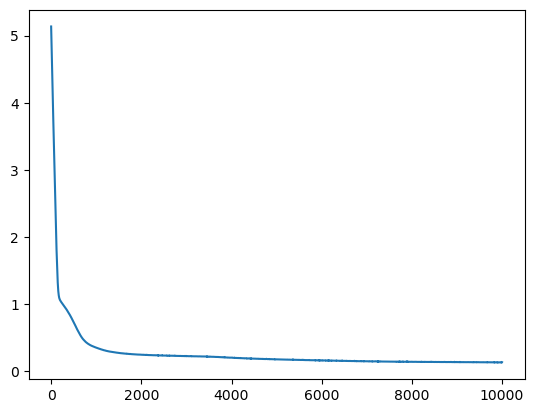

In [87]:
plt.plot(mlp_regr.loss_curve_)

## Объяснения

### SHAP

In [88]:

shap.initjs()

In [90]:
X_train

,util_per_offer_sim,util_per_offer_kk,util_per_offer_invest,violations,game,success,refuse_pct
0,0.025210,0.039216,0.015385,0.007519,0.093617,0.904762,0.000000
1,0.029197,0.023810,0.000000,0.012346,0.096916,0.870968,0.010753
2,0.000000,0.057692,0.017544,0.064103,0.150485,0.838710,0.021505
3,0.072581,0.067568,0.000000,0.064000,0.245211,0.946970,0.022727
4,0.058608,0.021277,0.018349,0.059748,0.081933,0.798995,0.000000
...,...,...,...,...,...,...,...
226,0.135810,0.068669,0.020041,0.007564,0.230108,0.929925,0.000000
227,0.326031,0.121756,0.012079,0.106590,0.307821,0.957725,0.000000
228,0.094946,0.054388,0.005382,0.002111,0.157428,0.901405,0.009602
229,0.114481,0.086782,0.006012,0.004603,0.201761,0.903519,0.009168


In [91]:
masker = shap.maskers.Independent(data = X_train)
explainer = shap.KernelExplainer(forest_regr.predict, X_train)


Using 231 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [92]:
# idx = 8
idx = 31
shap_values = explainer.shap_values(X_test.iloc[idx, 0:])
res = shap.plots.force(explainer.expected_value, shap_values, np.round(X_test.iloc[idx, 0:], 3), feature_names = ['Утиль Сим', 'Утиль Кредит', 'Утиль Инвест', 'Нарушения', 'Геймификация', 'Успешность', "Процент отказов"], show=False, matplotlib=False)
# shap_values
# plt.savefig("shap.png")
# shap.summary_plot(shap_values, X_test)

In [93]:
res.matplotlib(figsize=(10,10),show=False, text_rotation=30)
plt.savefig('shap.png')

In [97]:
rep = pd.DataFrame([X_test.iloc[idx, 0:].round(2)])
rep.loc['shap'] = np.round(shap_values, 2)
rep.columns = ['Утиль Сим', 'Утиль Кредит', 'Утиль Инвест', 'Нарушения', 'Геймификация', 'Успешность', "Процент отказов"]
rep

,Утиль Сим,Утиль Кредит,Утиль Инвест,Нарушения,Геймификация,Успешность,Процент отказов
41,0.19,0.07,0.00,0.03,0.23,0.93,0.01
shap,0.92,0.52,-0.13,-0.09,0.07,0.52,0.08


In [98]:
explainer.expected_value + shap_values.sum()

4.395

In [99]:
explainer.expected_value

2.5034415584415584

In [100]:
X_test.iloc[2, 0:], Y_test.iloc[2]

(util_per_offer_sim       0.030303
 util_per_offer_kk        0.142857
 util_per_offer_invest    0.000000
 violations               0.000000
 game                     0.065217
 success                  0.870968
 refuse_pct               0.000000
 Name: 22, dtype: float64,
 4.5)

In [101]:
X_train.columns

Index(['util_per_offer_sim', 'util_per_offer_kk', 'util_per_offer_invest',
       'violations', 'game', 'success', 'refuse_pct'],
      dtype='object')

### LIME

In [104]:
from lime import lime_tabular

In [105]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
lime_explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="regression", feature_names= colnames)
lime_explainer

In [106]:
idx = 31

print("Prediction : ", mlp_regr.predict(X_test.iloc[idx].values.reshape(1,-1)))
print("Actual :     ", Y_test.iloc[idx])
explanation = lime_explainer.explain_instance(X_test.iloc[idx], mlp_regr.predict, num_features=len(colnames))
explanation

Prediction :  [4.34413064]
Actual :      4.0


In [107]:
explanation.show_in_notebook()

In [109]:
ppf = explanation.as_pyplot_figure()

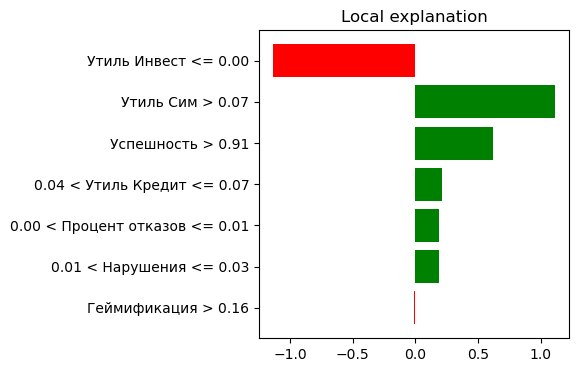

In [110]:
ppf

In [111]:
X_test.iloc[idx].values.reshape(1,-1)

array([[0.19310345, 0.06944444, 0.        , 0.03125   , 0.22591362,
        0.93023256, 0.00581395]])

In [113]:
mlp_regr.predict(data.set_index('id').loc[266061, ['util_per_offer_sim', 'util_per_offer_kk',
       'util_per_offer_invest', 'violations', 'game', 'success', 'refuse_pct']].values.reshape(1,-1))

array([1.55212474])

### Визуализация и отчеты

In [114]:
def visualize(df, path):
    fig, axs = plt.subplots(4, 2, figsize=(6, 12))  # Создание сетки графиков размером 4x2
    # Построение каждого столбца в отдельном подграфике
    for i, column in enumerate(df.columns):
        ax = axs[i//2, i%2]  # Выбор текущего подграфика из сетки
        ax.plot(df.index[0:2], df[column][0:2], marker='o', linestyle='-')  # Построение линии между первыми двумя точками
        # Сделать линию от второй к третьей точке пунктирной
        ax.plot(df.index[1:3], df[column][1:3], marker='o', linestyle='--', color='orange')
        # Сделать третью точку пустой
        ax.plot(df.index[2], df[column][2], marker='o', markersize=10, markerfacecolor='w', markeredgewidth=2, linestyle='None', color='orange')
        ax.set_title(column)  # Установка заголовка текущего подграфика
        ax.tick_params(axis='x', labelsize=8)  # Установка размера меток по оси X
    plt.subplots_adjust(hspace=0.5, wspace=0.5)  # Настройка интервалов между подграфиками

    plt.savefig(path)  # Сохранение графика в файл
    return path  # Возврат пути к сохраненному файлу


In [115]:
def report(period1, period2, id, model):
    # Получение данных по идентификатору из каждого периода
    period1_row = period1.set_index('id').loc[id, ['util_per_offer_sim', 'util_per_offer_kk',
       'util_per_offer_invest', 'violations', 'game', 'success', 'refuse_pct']]
    period2_row = period2.set_index('id').loc[id, ['util_per_offer_sim', 'util_per_offer_kk',
       'util_per_offer_invest', 'violations', 'game', 'success', 'refuse_pct']]
    period1_row.name = "Период 1"  # Установка имени для строки данных из первого периода
    period2_row.name = "Период 2"  # Установка имени для строки данных из второго периода
    
    # Предсказание на основе модели
    prediction = model.predict(pd.concat([period1_row, period2_row]).values.reshape(1, -1))[0]
    
    # Создание DataFrame с данными из обоих периодов и предсказанием
    res = pd.DataFrame([period1_row, period2_row])
    res.loc['Предсказание'] = prediction  # Добавление строки с предсказанием в DataFrame
    res.columns = colnames  # Установка названий столбцов DataFrame
    
    # Получение входных данных для оценки изменения
    inp = res.loc[['Период 1', "Период 2", "Предсказание"]].values
    
    # Получение оценки изменения
    res.loc[['Период 1', "Период 2", "Предсказание"], 'Оценка'] = mlp_regr.predict(inp)
    
    # Вычисление процентного изменения за месяц и ожидаемого изменения
    res.loc["Изменение за месяц"] = res.pct_change().loc['Период 2'] * 100
    res.loc["Ожидаемое изменение"] = res.pct_change().loc['Предсказание'] * 100

    return res  # Возврат DataFrame с отчетом


In [116]:
reported = report(data_jan, data, 220451, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [117]:
plot1 = visualize(reported.loc[['Период 1', "Период 2", "Предсказание"]], "graph.png")

In [118]:
negative = pd.Series([1,1,1,-1,1,1,-1], index=X.columns)

In [119]:
negative

util_per_offer_sim       1
util_per_offer_kk        1
util_per_offer_invest    1
violations              -1
game                     1
success                  1
refuse_pct              -1
dtype: int64

In [120]:
idx=6
X_tmp = X*negative
t =(((X_tmp < X_tmp.loc[X_test.iloc[idx].name]).mean(axis=0)))

In [121]:
np.round(shap_values[t.argmax()], 2)

0.52

In [122]:
t

util_per_offer_sim       0.000000
util_per_offer_kk        0.964824
util_per_offer_invest    0.000000
violations               0.130653
game                     0.934673
success                  0.040201
refuse_pct               0.723618
dtype: float64

In [123]:
colnames[t.argmax()], int(np.round(t.max() * 100, 0))

('Утиль Кредит', 96)

In [124]:
data_cols = ['util_per_offer_sim', 'util_per_offer_kk',
       'util_per_offer_invest', 'violations', 'game', 'success', 'refuse_pct']

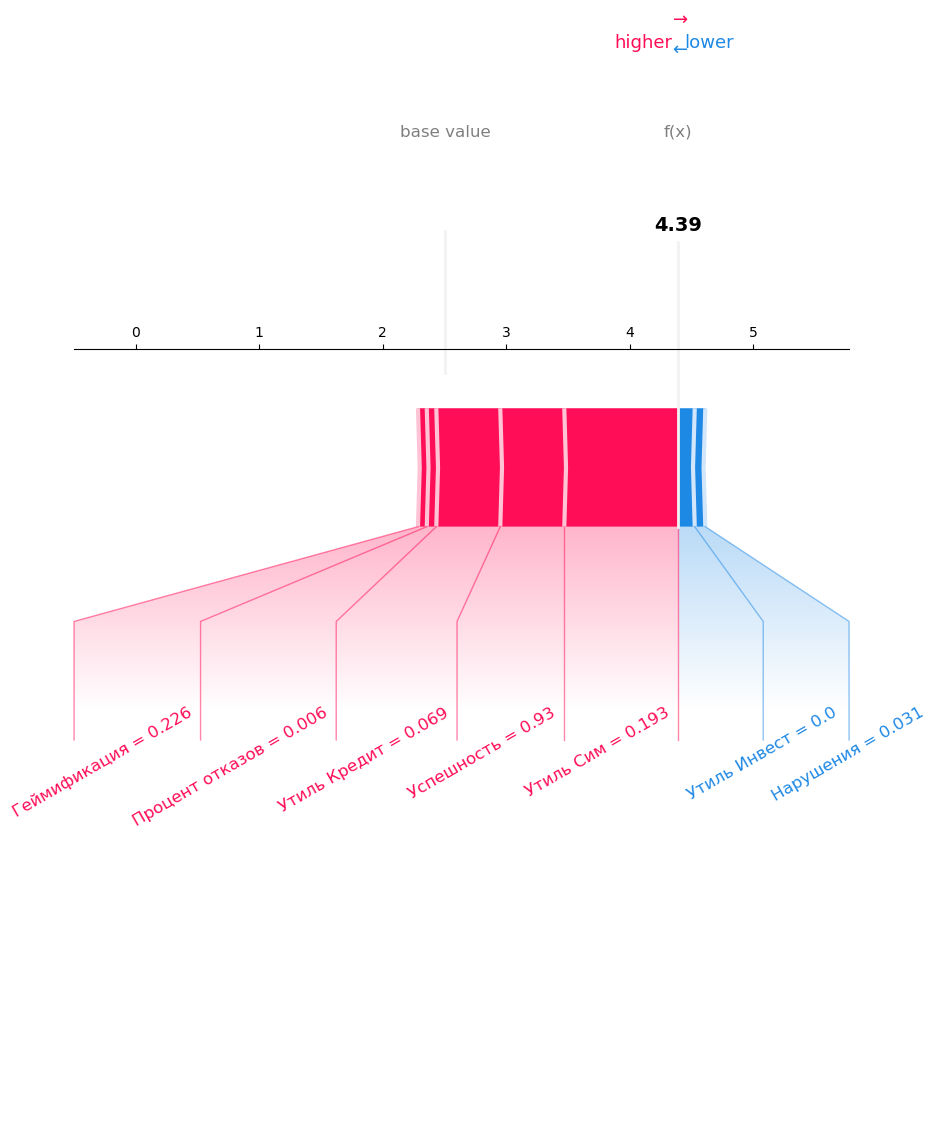

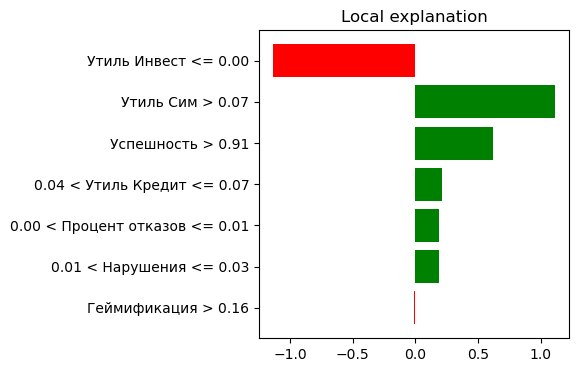

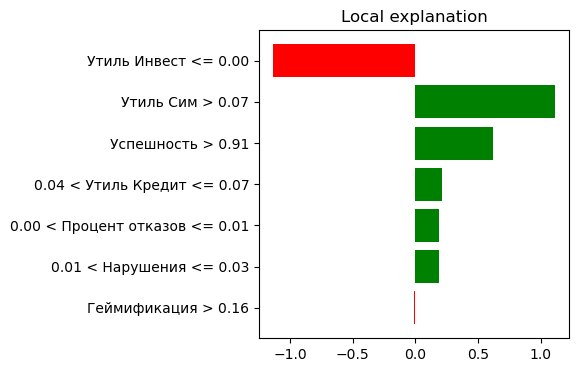

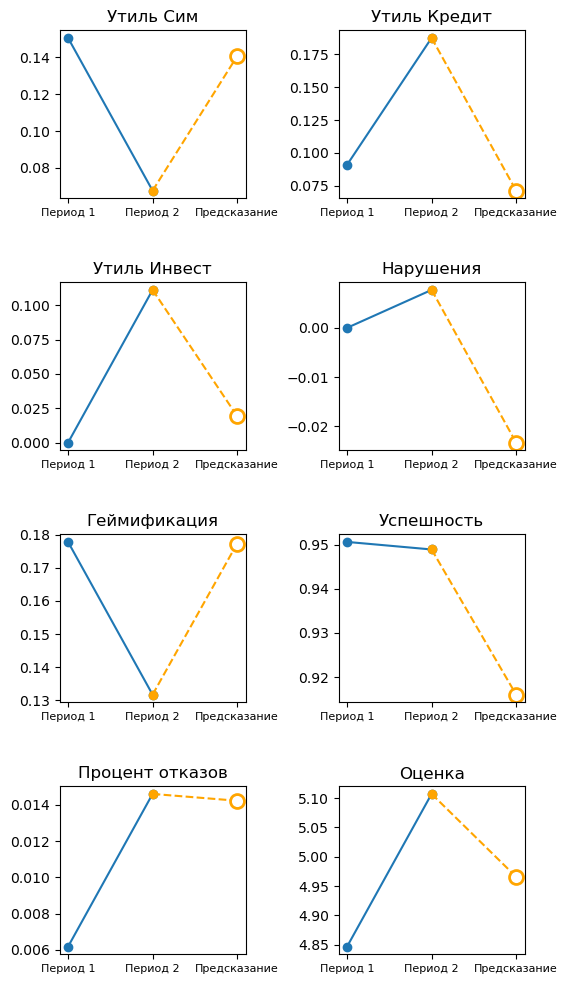

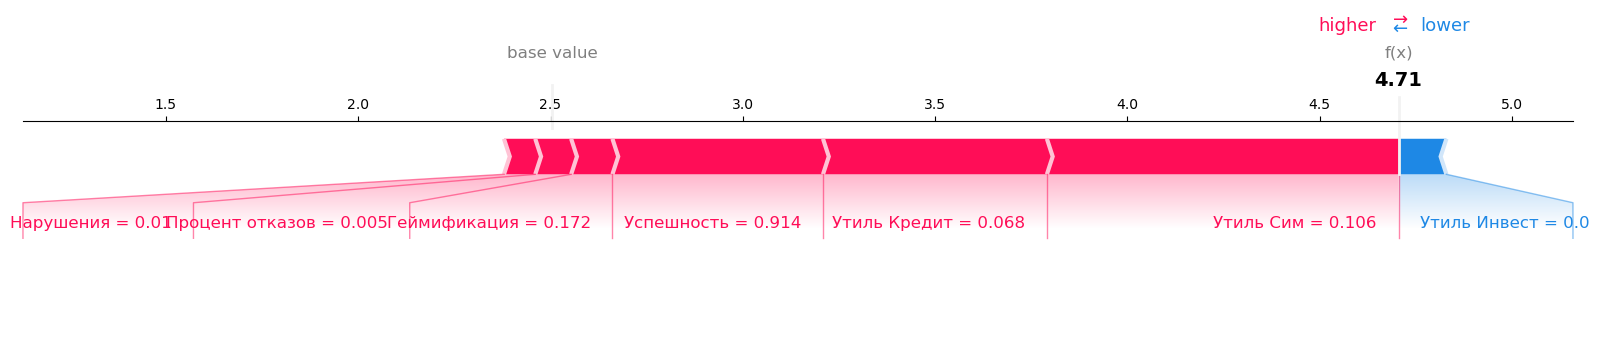

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


,Период 1,Период 2,Предсказание,Изменение за месяц,Ожидаемое изменение
Утиль Сим,0.175000,0.125000,-0.012643,-28.571429,-110.114381
Утиль Кредит,0.063492,0.260274,-0.077461,309.931507,-129.761170
Утиль Инвест,0.016393,0.029703,-0.068991,81.188119,-332.270170
Нарушения,0.142857,1.200000,0.912250,740.000000,-23.979138
Геймификация,0.377451,0.510989,-0.121124,35.378907,-123.703921
Успешность,0.929204,0.833333,0.431812,-10.317460,-48.182533
Процент отказов,0.008850,0.166667,0.009154,1783.333333,-94.507662
Оценка,3.616558,1.552125,-3.436719,-57.082819,-321.420268


In [126]:
id_ = 261755
shap_values = explainer.shap_values(np.round(data.set_index('id').loc[id_, data_cols], 3))
shap.plots.force(explainer.expected_value, shap_values, np.round(data.set_index('id').loc[id_, data_cols,], 3), matplotlib = True, feature_names = ['Утиль Сим', 'Утиль Кредит', 'Утиль Инвест', 'Нарушения', 'Геймификация', 'Успешность', "Процент отказов"])
explanation = lime_explainer.explain_instance(data.set_index('id').loc[id_, data_cols], mlp_regr.predict, num_features=len(colnames))
explanation.as_pyplot_figure()
reported = report(data_jan, data, 266061, model)
visualize(reported.loc[['Период 1', "Период 2", "Предсказание"]], "graph.png")
reported.T